In [1]:
import os
import os.path as osp
import glob
from PIL import Image
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms

In [2]:
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
class Dataset(data.Dataset):
    def __init__(self, file_paths_list, transform, phase):
        self.file_paths_lsit = file_paths_list
        self.transform = transform
        self.train = True if phase=="train" else False
        
    def __len__(self):
        return len(self.file_paths_lsit)
    
    def __getitem__(self, index):
        # 読み込み
        path = self.file_paths_lsit[index]
        img = Image.open(path) # [高さ][幅][色RGB]
        
        # 前処理
        img_transformed = self.transform(img)
        
        # ラベル
        label = path.split("/")[4]
        label = CLASSES.index(label)
        
#         return img_transformed, label
        return path, img_transformed, label

In [3]:
# ファイルのpathリスト作成
train_dataset_paths = "./dataset/cifar/train/*/*"
test_dataset_paths = "./dataset/cifar/test/*/*"

train_dataset_paths_list = [_ for _ in glob.glob(train_dataset_paths)]
test_dataset_paths_list = [_ for _ in glob.glob(test_dataset_paths)]

In [4]:
print("len(train_dataset_paths_list):", len(train_dataset_paths_list)) # 6クラス * 5000枚/クラス = 30000枚
print("len(test_dataset_paths_list):", len(test_dataset_paths_list))

len(train_dataset_paths_list): 30000
len(test_dataset_paths_list): 4000


In [5]:
# 前処理インスタンスの定義
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [8]:
# train_datasetインスタンスの宣言
train_dataset = Dataset(train_dataset_paths_list, data_transforms, "train")

In [9]:
# データのラベルを格納したリスト
train_labels = np.array([train_dataset[index][2] for index in range(len(train_dataset))])

In [13]:
from torch.utils.data import BatchSampler
class BalancedBatchSampler(BatchSampler):
    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels))
        self.label_to_indices = {label: np.where(self.labels == label)[0] for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][self.used_label_indices_count[class_]:self.used_label_indices_count[class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [72]:
train_batch_sampler = BalancedBatchSampler(train_labels, 6, 200)

In [73]:
online_train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=train_batch_sampler, num_workers=1)

In [74]:
# Embedding Net
class EmbeddingNet(nn.Module):
    """ Basic Embedding Network
    """
    def __init__(self, fc_input_size=64*6*6):
        super(EmbeddingNet, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=0),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    nn.Conv2d(32, 64, 3),
                                    nn.ReLU(),
                                    nn.MaxPool2d(kernel_size=2, stride=2),
                                    )
        self.fc = nn.Sequential(nn.Linear(fc_input_size, 256),
                                nn.ReLU(),
                                nn.Linear(256, 64),
                                )
    
    def forward(self, x):
        """ convnet -> flatten -> fc 
            input: torch.Size([batch_size, 3, 64, 64])
            output: torch.Size([batch_size, 64])
        """
        x = self.convnet(x)
        batch_size = x.size(0)
        x = x.view(batch_size, -1) # flatten
        x = self.fc(x)
        return x


class EmbeddingNetL2(EmbeddingNet):
    """ output l2 norm
    """
    def __init__(self):
        super(EmbeddingNetL2, self).__init__()

    def forward(slef, x):
        x = super(EmbeddingNetL2, self).forward(x)
        x /= x.pow(2).sum(1, keepdim=True).sqrt()
        return x

In [75]:
# 損失関数の定義
class OnlineTripletLoss(nn.Module):
    """
    Online Triplets loss
    Takes a batch of embeddings and corresponding labels.
    Triplets are generated using triplet_selector object that take embeddings and targets and return indices of
    triplets
    """

    def __init__(self, margin, triplet_selector):
        super(OnlineTripletLoss, self).__init__()
        self.margin = margin
        self.triplet_selector = triplet_selector

    def forward(self, embeddings, target):

        triplets = self.triplet_selector.get_triplets(embeddings, target)

        if embeddings.is_cuda:
            triplets = triplets.cuda()

        ap_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 1]]).pow(2).sum(1)  # .pow(.5)
        an_distances = (embeddings[triplets[:, 0]] - embeddings[triplets[:, 2]]).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(ap_distances - an_distances + self.margin)

        return losses.mean(), len(triplets)

In [76]:
# Mining Method
from itertools import combinations

def pdist(vectors):
    distance_matrix = -2 * vectors.mm(torch.t(vectors)) + vectors.pow(2).sum(dim=1).view(1, -1) + vectors.pow(2).sum(
        dim=1).view(-1, 1)
    return distance_matrix

class TripletSelector:
    """
    Implementation should return indices of anchors, positive and negative samples
    return np array of shape [N_triplets x 3]
    """

    def __init__(self):
        pass

    def get_triplets(self, embeddings, labels):
        raise NotImplementedError


class AllTripletSelector(TripletSelector):
    """
    Returns all possible triplets
    May be impractical in most cases
    """

    def __init__(self):
        super(AllTripletSelector, self).__init__()

    def get_triplets(self, embeddings, labels):
        labels = labels.cpu().data.numpy()
        triplets = []
        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs

            # Add all negatives for all positive pairs
            temp_triplets = [[anchor_positive[0], anchor_positive[1], neg_ind] for anchor_positive in anchor_positives
                             for neg_ind in negative_indices]
            triplets += temp_triplets

        return torch.LongTensor(np.array(triplets))


def hardest_negative(loss_values):
    hard_negative = np.argmax(loss_values)
    return hard_negative if loss_values[hard_negative] > 0 else None


def random_hard_negative(loss_values):
    hard_negatives = np.where(loss_values > 0)[0]
    return np.random.choice(hard_negatives) if len(hard_negatives) > 0 else None


def semihard_negative(loss_values, margin):
    semihard_negatives = np.where(np.logical_and(loss_values < margin, loss_values > 0))[0]
    return np.random.choice(semihard_negatives) if len(semihard_negatives) > 0 else None


class FunctionNegativeTripletSelector(TripletSelector):
    """
    For each positive pair, takes the hardest negative sample (with the greatest triplet loss value) to create a triplet
    Margin should match the margin used in triplet loss.
    negative_selection_fn should take array of loss_values for a given anchor-positive pair and all negative samples
    and return a negative index for that pair
    """

    def __init__(self, margin, negative_selection_fn, cpu=True):
        super(FunctionNegativeTripletSelector, self).__init__()
        self.cpu = cpu
        self.margin = margin
        self.negative_selection_fn = negative_selection_fn

    def get_triplets(self, embeddings, labels):
        if self.cpu:
            embeddings = embeddings.cpu()
        distance_matrix = pdist(embeddings)
        distance_matrix = distance_matrix.cpu()

        labels = labels.cpu().data.numpy()
        triplets = []

        for label in set(labels):
            label_mask = (labels == label)
            label_indices = np.where(label_mask)[0]
            if len(label_indices) < 2:
                continue
            negative_indices = np.where(np.logical_not(label_mask))[0]
            anchor_positives = list(combinations(label_indices, 2))  # All anchor-positive pairs
            anchor_positives = np.array(anchor_positives)

            ap_distances = distance_matrix[anchor_positives[:, 0], anchor_positives[:, 1]]
            for anchor_positive, ap_distance in zip(anchor_positives, ap_distances):
                loss_values = ap_distance - distance_matrix[torch.LongTensor(np.array([anchor_positive[0]])), torch.LongTensor(negative_indices)] + self.margin
                loss_values = loss_values.data.cpu().numpy()
                hard_negative = self.negative_selection_fn(loss_values)
                if hard_negative is not None:
                    hard_negative = negative_indices[hard_negative]
                    triplets.append([anchor_positive[0], anchor_positive[1], hard_negative])

        if len(triplets) == 0:
            triplets.append([anchor_positive[0], anchor_positive[1], negative_indices[0]])

        triplets = np.array(triplets)

        return torch.LongTensor(triplets)


def HardestNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                 negative_selection_fn=hardest_negative,
                                                                                 cpu=cpu)


def RandomNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                negative_selection_fn=random_hard_negative,
                                                                                cpu=cpu)


def SemihardNegativeTripletSelector(margin, cpu=False): return FunctionNegativeTripletSelector(margin=margin,
                                                                                  negative_selection_fn=lambda x: semihard_negative(x, margin),
                                                                                  cpu=cpu)

In [90]:
margin = 5
embedding_net = EmbeddingNet()
model = embedding_net.cuda()
loss_fn = OnlineTripletLoss(margin, SemihardNegativeTripletSelector(margin))
lr = 1e-3
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, 8, gamma=0.1, last_epoch=-1)
n_epochs = 100
log_interval = 50

In [91]:
import time

# 時間計測開始
time_sta = time.perf_counter()

# fit 関数をそのまま書く
start_epoch = 0
losses = []
total_loss = 0

# train
for epoch in range(start_epoch, n_epochs):
    scheduler.step()
    model.train()
    losses = []
    total_loss = 0
    for batch_idx, (paths, datas, labels) in enumerate(online_train_loader):
        datas = datas.cuda()
        optimizer.zero_grad()
        outputs = model(datas) # data = ([(x11, x12), (x21, x22), ....])
        loss_outputs = loss_fn(outputs, labels)
        loss = loss_outputs[0]
        losses.append(loss.item())
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    time_end = time.perf_counter()
    # 経過時間（秒）
    tim = time_end- time_sta
    print("epoch:", epoch, "loss:", loss.item(), "time:", tim)

/home/gesogeso/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:82: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


epoch: 0 loss: 2.5058395862579346 time: 360.51487625797745
epoch: 1 loss: 2.502445936203003 time: 723.85582763399
epoch: 2 loss: 2.4965481758117676 time: 1088.8686374889803
epoch: 3 loss: 2.4893510341644287 time: 1455.746079583012
epoch: 4 loss: 2.4936649799346924 time: 1821.9782931489754
epoch: 5 loss: 2.4918899536132812 time: 2187.7170970389852
epoch: 6 loss: 2.4973065853118896 time: 2551.3060879089753
epoch: 7 loss: 2.4908149242401123 time: 2915.025392053998
epoch: 8 loss: 2.4927570819854736 time: 3278.469888828986
epoch: 9 loss: 2.4900927543640137 time: 3644.7657555749756
epoch: 10 loss: 2.4854559898376465 time: 4012.0248259939835
epoch: 11 loss: 2.483659505844116 time: 4379.573402801994
epoch: 12 loss: 2.4897186756134033 time: 4746.832968865987
epoch: 13 loss: 2.478012800216675 time: 5114.473344649014
epoch: 14 loss: 2.4852797985076904 time: 5478.266801997961
epoch: 15 loss: 2.4918460845947266 time: 5843.097244375967
epoch: 16 loss: 2.481646776199341 time: 6212.294104152999
epoch:

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
CLASSES = ["bird", "cat", "deer", "dog", "frog", "horse"]
classes_num = [i for i in range(len(CLASSES))]
colors = ["red", "blue", "pink", "orange", "yellow", "green"]
def plot_embeddings(embeddings, targets, xlim=None, ylim=None):
    plt.figure(figsize=(10,10))
    for i in range(len(CLASSES)):
        inds = np.where(targets==i)[0]
        plt.scatter(embeddings[inds,0], embeddings[inds,1], alpha=0.5, color=colors[i])
    if xlim:
        plt.xlim(xlim[0], xlim[1])
    if ylim:
        plt.xlim(ylim[0], ylim[1])
    plt.legend(CLASSES)

def extract_embeddings(dataloader, model):
    with torch.no_grad():
        model.eval()
        embeddings = np.zeros((len(dataloader.dataset), 64))
        labels = np.zeros(len(dataloader.dataset))
        k = 0
        for paths, images, targets in dataloader:
            embeddings[k:k+len(images)] = model.forward(images).data.cpu().numpy()
            labels[k:k+len(images)] = targets.numpy()
            k += len(images)
    return embeddings, labels

In [93]:
model.cpu()
batch_size = 120
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
train_embeddings, train_labels = extract_embeddings(train_loader, model)

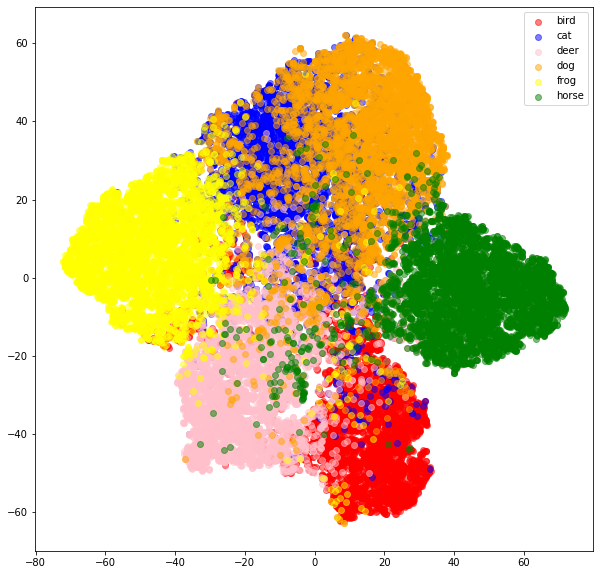

In [40]:
# RandomNegativeTripletSelector # margin:1 # epoch: 20
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

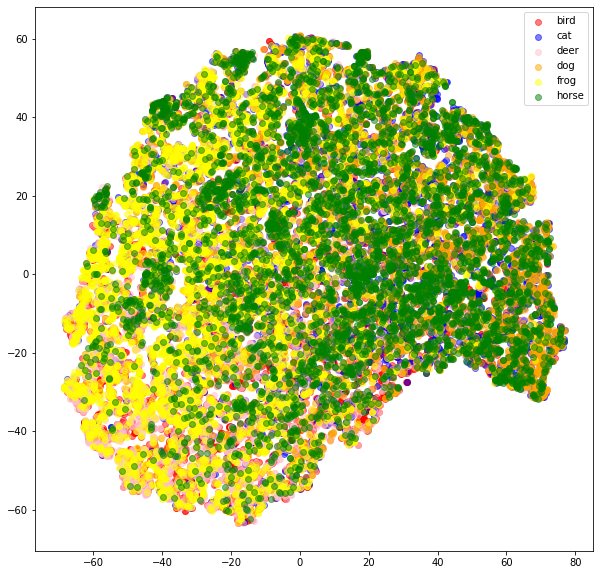

In [44]:
# SemiHardNegativeTripletSelector # margin:1 # epoch: 20
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

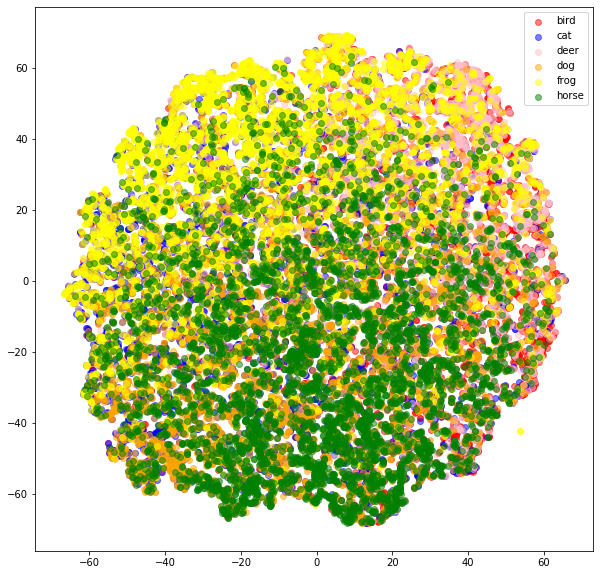

In [48]:
# SemiHardNegativeTripletSelector # margin:10 # epoch: 20  # batch_n :3
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

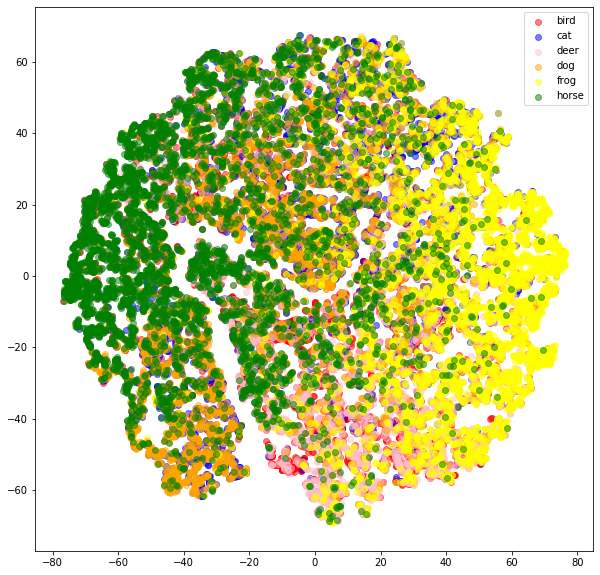

In [58]:
# SemiHardNegativeTripletSelector # margin:10 # epoch: 20, # batch_n :6
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

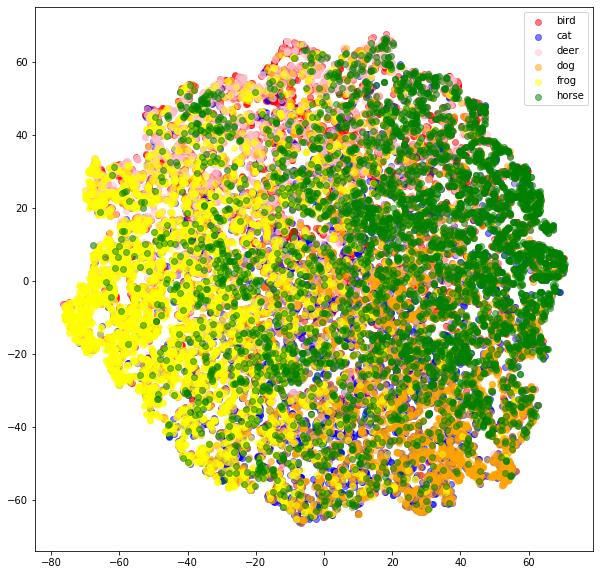

In [62]:
# SemiHardNegativeTripletSelector # margin:30 # epoch: 20, # batch_n :6 #barch_m: 20
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

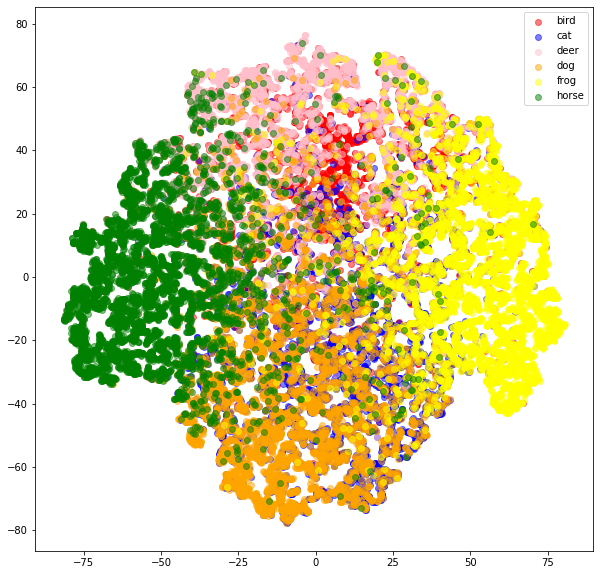

In [71]:
# SemiHardNegativeTripletSelector # margin:30 # epoch: 20, # batch_n :6 #barch_m: 100 (1epoch: 160s)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

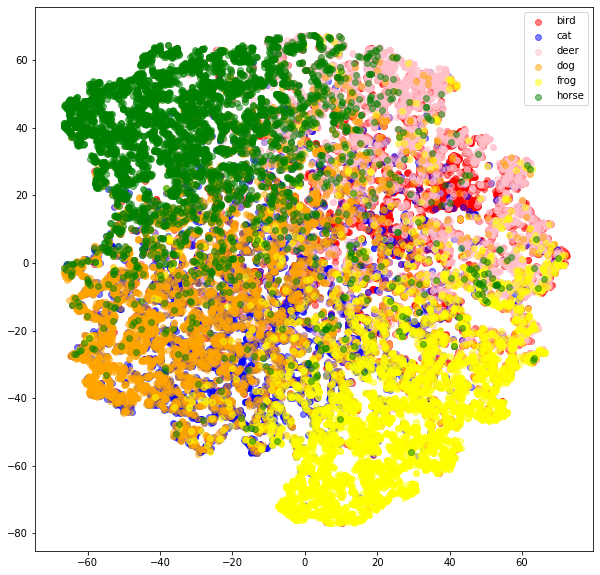

In [83]:
# SemiHardNegativeTripletSelector # margin:5 # epoch: 20, # batch_n :6 #barch_m: 200 (1epoch: 358s)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

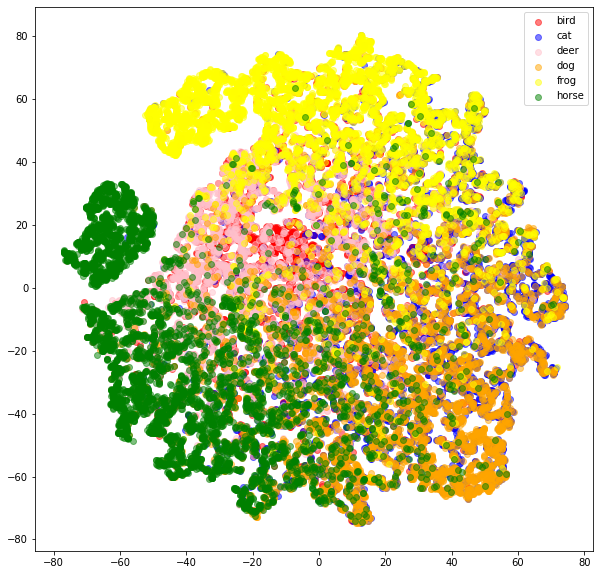

In [89]:
# SemiHardNegativeTripletSelector # margin:5 # epoch: 20, # batch_n :6 #barch_m: 200 (1epoch: 358s)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)

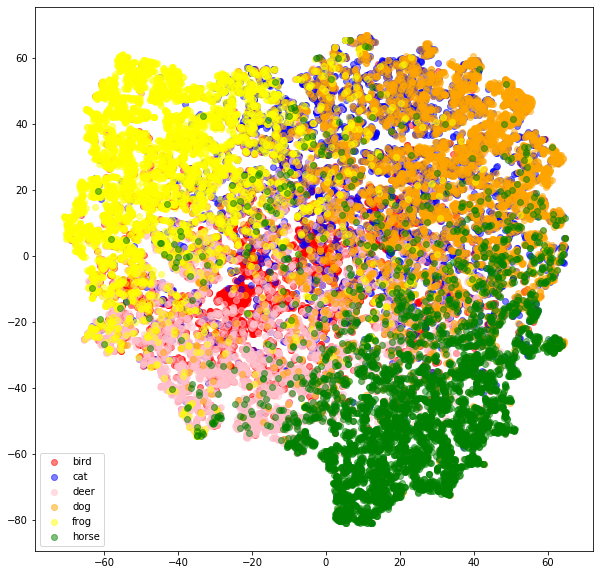

In [94]:
# SemiHardNegativeTripletSelector # margin:5 # epoch: 100, # batch_n :6 #barch_m: 200 (1epoch: 358s)
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(train_embeddings)
plot_embeddings(X_embedded, train_labels)